In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import pickle

from torchvision.datasets import MNIST

from dataset_builder import *

In [4]:
train_loader, test_loader, mnist = prepare_semisupervised_mnist_data(subset_ratio = 0.20, train_ratio=0.75, batchsize=128)

Dataset preparato:
- Subset totale: 12000 campioni
- Training set: 9000 campioni
- Test set: 3000 campioni
- Batch size: 128


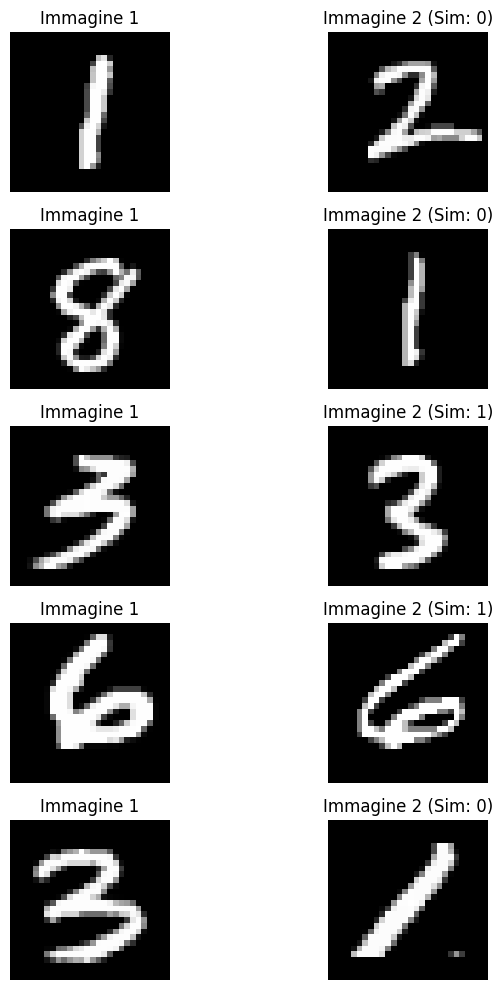

In [5]:
visualize_pairs(train_loader.dataset)

In [6]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0, w = 1): # prova ad aumentare il margin
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.w = w
    def forward(self, output1, output2, label):
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((label) * 0.5 * torch.pow(euclidean_distance, 2) +
                                    (1-label) * 0.5 * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))*self.w

      return loss_contrastive

In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size = 2):
        super(SiameseNetwork, self).__init__()

        # CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )

        # fully connected layers
        self.fc1 = nn.Sequential(
            
            nn.Linear(256 * 3 * 3, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, embedding_size)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [8]:
def train_model(model, train_loader, optimizer, criterion, epochs):

    counter = []
    loss_history = [] 
    iteration_number= 0

    for epoch in range(epochs):

        for i, (img0, img1, label) in enumerate(train_loader, 0):

            optimizer.zero_grad()
            output1, output2 = model(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            optimizer.step()
            if i % 50 == 0 :
                print(f"Epoch {epoch} batch {i}\nloss {loss_contrastive.item()}\n")
                iteration_number += 10

                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    
    return (counter, loss_history)

In [17]:
def test_trained_model(model, dataset, num_examples=5, verbose = True):
    """
    Testa il modello trainato su alcuni esempi
    """
    giuste = 0
    sbagliate = 0
    model.eval()
    device = next(model.parameters()).device
    
    if verbose:
        print(f"Test del modello su {num_examples} esempi:")
        print("-" * 60)
    
    for i in range(num_examples):
        img1, img2, true_label = dataset[i]
        
        # Aggiungi dimensione batch
        img1 = img1.unsqueeze(0).to(device)
        img2 = img2.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output1, output2 = model(img1, img2)
            euclidean_distance = F.pairwise_distance(output1, output2)
            similarity = torch.exp(-euclidean_distance)
            predicted_label = 1 if similarity.item() > 0.5 else 0
        
        if predicted_label == true_label:
            giuste +=1
        else:
            sbagliate +=1
    
    if verbose:
        print("Il modello ne ha beccate: " + str(giuste))
        print("Il modello ne ha sbagliate: " + str(sbagliate))

    accuracy = giuste/num_examples
    return accuracy

In [9]:
net = SiameseNetwork(embedding_size = 64)
criterion = ContrastiveLoss(margin=2.0, w = 1)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.00001)

counter, loss_history = train_model(net, train_loader, optimizer, criterion, epochs = 20)


Epoch 0 batch 0
loss 0.8052181601524353

Epoch 0 batch 50
loss 0.6494677066802979

Epoch 1 batch 0
loss 0.6630192399024963

Epoch 1 batch 50
loss 0.5395370125770569

Epoch 2 batch 0
loss 0.5594260096549988

Epoch 2 batch 50
loss 0.537153422832489

Epoch 3 batch 0
loss 0.5345017313957214

Epoch 3 batch 50
loss 0.5536913871765137

Epoch 4 batch 0
loss 0.5329017043113708

Epoch 4 batch 50
loss 0.5482187271118164

Epoch 5 batch 0
loss 0.5311009883880615

Epoch 5 batch 50
loss 0.5507034063339233

Epoch 6 batch 0
loss 0.5351160168647766

Epoch 6 batch 50
loss 0.5447672605514526

Epoch 7 batch 0
loss 0.5345244407653809

Epoch 7 batch 50
loss 0.5401508808135986

Epoch 8 batch 0
loss 0.5314702987670898

Epoch 8 batch 50
loss 0.5223910212516785

Epoch 9 batch 0
loss 0.5322027802467346

Epoch 9 batch 50
loss 0.5266230702400208

Epoch 10 batch 0
loss 0.5298770666122437

Epoch 10 batch 50
loss 0.513596773147583

Epoch 11 batch 0
loss 0.525101900100708

Epoch 11 batch 50
loss 0.5251467823982239

Epo

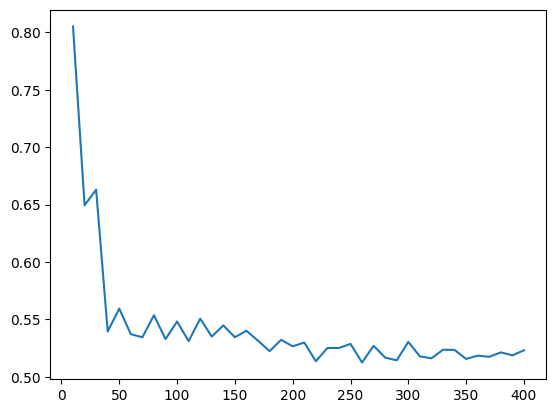

In [16]:
plt.plot(counter, loss_history)

In [18]:
_ = test_trained_model(net, test_loader.dataset, num_examples=100)

Test del modello su 100 esempi:
------------------------------------------------------------
Il modello ne ha beccate: 60
Il modello ne ha sbagliate: 40


In [19]:
campioni = 100
tests = [test_trained_model(net, test_loader.dataset, num_examples=100, verbose=False) for i in range(campioni)]

print("Accuracy media: " +str(np.mean(tests)))
print("Varianza accuracy: " + str(np.var(tests)))

Accuracy media: 0.5617
Varianza accuracy: 0.0022961099999999996


In [20]:
test_accuracy = test_trained_model(net, test_loader.dataset, num_examples=len(test_loader.dataset))

Test del modello su 3000 esempi:
------------------------------------------------------------
Il modello ne ha beccate: 1674
Il modello ne ha sbagliate: 1326


In [ ]:

# salvataggio modello
# with open("models/SSN (56acc-128bs).pkl", "wb") as f:
#     pickle.dump(net, f)

---
